## Download dataset and set up the data folder

In [3]:
## Download the dataset from github repo
!wget https://media.githubusercontent.com/media/SIGCOMM22-5GMobility/artifact/dev/raw-data/D1.csv
!wget https://media.githubusercontent.com/media/SIGCOMM22-5GMobility/artifact/dev/raw-data/D2.csv

--2022-06-26 00:15:42--  https://media.githubusercontent.com/media/SIGCOMM22-5GMobility/artifact/dev/raw-data/D1.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345077566 (329M) [text/plain]
Saving to: ‘D1.csv’

D1.csv              100%[===================>] 329.09M   283MB/s    in 1.2s    

2022-06-26 00:15:44 (283 MB/s) - ‘D1.csv’ saved [345077566/345077566]

--2022-06-26 00:15:44--  https://media.githubusercontent.com/media/SIGCOMM22-5GMobility/artifact/dev/raw-data/D2.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 20

In [4]:
## configure directory where data is stored
import os
DATA_FOLDER = os.path.curdir

## Import packages

In [5]:
#!/usr/bin/env python3
import random
import pprint
import numpy as np
import pandas as pd
from os import path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, plot_roc_curve

# from utils.context import data_dir_shared_pred

np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.3f' % x)

## Configure the parameters for data processing and training

```Split method```:
Split the whole database into split 1 and split 2 based on the ratio. Do the negative sampling on split 1 for training. Test the model on split 2.



In [13]:
####################################
### Config
####################################
PARAMETERS = {}

# Read Database
PARAMETERS["data_folder"] = DATA_FOLDER
PARAMETERS["file_name"] = "D1"
# PARAMETERS["file_name"] = "D2"

# Task
PARAMETERS["label"] = "all_ho_category"
PARAMETERS["binary"] = True
PARAMETERS["feature_list"] = ["lon", "lat", 'speed', 'lte_serv_rsrp', 'lte_serv_rsrq', 'lte_serv_rssi','lte_nbr_rsrp', 'lte_nbr_rsrq', 'lte_cqi0', 'lte_cqi1', 'dl_tput', \
                              'nr_serv_rsrp', 'nr_serv_rsrq', 'nr_serv_sinr', 'nr_cqi', 'nr_nbr_rsrp', 'nr_nbr_rsrq']  # , 'irat_rsrp', 'irat_rsrq'

# Process the dataset 
PARAMETERS["split_mode"] = "train_neg_sampling"

####################################
### Config (Hyper-parameters) 
####################################
# Read Database
PARAMETERS["sample_rate"] = 50  # ms 

# Process the dataset 
PARAMETERS["train_ratio"] = 0.7
PARAMETERS["hist_window"] = 20
PARAMETERS["pred_window"] = 20
if PARAMETERS["file_name"] == "D1":
  PARAMETERS["neg_size"] = 10000
elif PARAMETERS["file_name"] == "D2":
  PARAMETERS["neg_size"] = 50000
  
# Machine Learning 
PARAMETERS["batch_size"] = 64
PARAMETERS["epochs"] = 200
PARAMETERS["latent_dim"] = 32

## Preprocess the data
It will take a couple of minutes (D2 will take 15min in Colab).

In [19]:
class MyDataset:
    def __init__(self, PARAMETERS:dict):
        self.PARAMETERS = PARAMETERS
        self.df = self.read_data()     
        
        if self.PARAMETERS["binary"] == True:
            self.convert_binary_label()
            
        self.lte_le = preprocessing.LabelEncoder()
        self.nr_le = preprocessing.LabelEncoder()
        self.all_le = preprocessing.LabelEncoder()
        self.encode_label()
            
        if self.PARAMETERS["sample_rate"] != 0:
            self.sampled_df = self.sampling()
    
    
    def read_data(self):
        data_path = path.join(self.PARAMETERS["data_folder"], self.PARAMETERS["file_name"] + '.csv')
        df = pd.read_csv(data_path, low_memory=False)
        
        # Drop the first several rows
        df = df[3000:].reset_index(drop=True)                                   
        
        # Convert '2021-06-15 15:07:18.554116' to 1623769638554.116 (ms)
        df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP'])
        df['OLD_TIME_STAMP'] = df['TIME_STAMP']
        df["TIME_STAMP"] = (df["TIME_STAMP"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1us')
        df["TIME_STAMP"] = (df["TIME_STAMP"] - df["TIME_STAMP"][0])/1000
        
        # Merge "lte_ho_category" and "nr_ho_category"
        df["all_ho_category"] = df["lte_ho_category"] + " " + df["nr_ho_category"]

        return df
    
    
    def convert_binary_label(self):
        df = self.df
        df.loc[~(self.df["lte_ho_category"] == "no_handover"), "lte_ho_category"] = 1
        df.loc[self.df["lte_ho_category"] == "no_handover", "lte_ho_category"] = 0
        df.loc[~(self.df["nr_ho_category"] == "no_handover"), "nr_ho_category"] = 1
        df.loc[self.df["nr_ho_category"] == "no_handover", "nr_ho_category"] = 0
        df.loc[~(self.df["all_ho_category"] == "no_handover no_handover"), "all_ho_category"] = 1
        df.loc[self.df["all_ho_category"] == "no_handover no_handover", "all_ho_category"] = 0
        self.df = df
        
        
    def encode_label(self):
        df = self.df
        self.lte_le = preprocessing.LabelEncoder().fit(df["lte_ho_category"])
        df.loc[:, "lte_ho_category"] = self.lte_le.transform(df.loc[:, "lte_ho_category"])
        self.nr_le = preprocessing.LabelEncoder().fit(df["nr_ho_category"])
        df.loc[:, "nr_ho_category"] = self.nr_le.transform(df.loc[:, "nr_ho_category"])
        self.all_le = preprocessing.LabelEncoder().fit(df["all_ho_category"])
        df.loc[:, "all_ho_category"] = self.all_le.transform(df.loc[:, "all_ho_category"])
        self.df = df


    def sampling(self):
        df = self.df
        sample_rate = self.PARAMETERS["sample_rate"]  # default 50 ms
        bins = range(int(df['TIME_STAMP'].min()), int(df['TIME_STAMP'].max())+1, sample_rate)
        df['r_time'] = pd.cut(df['TIME_STAMP'], bins=bins, labels=bins[:-1], include_lowest=True)
        sampled_df = df.groupby('r_time').agg(lon=('lon', np.mean), 
                                              lat=('lat', np.mean),
                                              speed=('speed', np.mean),
                                              lte_serv_rsrp=('lte_serv_rsrp', np.mean),
                                              lte_serv_rsrq=('lte_serv_rsrq', np.mean),
                                              lte_serv_rssi=('lte_serv_rssi', np.mean),
                                              lte_cqi0=('lte_cqi0', np.mean),
                                              lte_cqi1=('lte_cqi1', np.mean),
                                              nr_serv_rsrp=('nr_serv_rsrp', np.mean),
                                              nr_serv_rsrq=('nr_serv_rsrq', np.mean),
                                              nr_serv_sinr=('nr_serv_sinr', np.mean),
                                              nr_cqi=('nr_cqi', np.mean),
                                              dl_tput=('dl_tput', np.mean),
                                              ul_tput=('ul_tput', np.mean),
                                              lte_nbr_rsrp=('lte_nbr_rsrp', np.mean),
                                              lte_nbr_rsrq=('lte_nbr_rsrq', np.mean),
                                              irat_rsrp=('irat_rsrp', np.mean),
                                              irat_rsrq=('irat_rsrq', np.mean),
                                              nr_nbr_rsrp=('nr_nbr_rsrp', np.mean),
                                              nr_nbr_rsrq=('nr_nbr_rsrq', np.mean),
                                              lte_ho_category=('lte_ho_category', np.max),
                                              nr_ho_category=('nr_ho_category', np.max),
                                              all_ho_category=('all_ho_category', np.max),) 
        # Padding 4*sample_rate=200 ms
        for col in sampled_df:
            if col =="r_time":
                continue
            else:
                sampled_df[col].fillna(method='ffill', limit=4, inplace=True)
                
        sampled_df.reset_index(level=0, inplace=True)
        return sampled_df


    def get_df(self):
        return self.df


    def get_sampled_df(self):
        return self.sampled_df


####################################
### Read and sample the database
####################################
Dataset = MyDataset(PARAMETERS)
df = Dataset.get_df()
print(df.columns)

sampled_df = Dataset.get_sampled_df()
display(sampled_df)

Index(['TIME_STAMP', 'lon', 'lat', 'speed', 'technology', 'lte_band',
       'lte_serv_rsrp', 'lte_serv_rsrq', 'lte_serv_rssi', 'lte_cqi0',
       'lte_cqi1', 'nr_band', 'nr_serv_rsrp', 'nr_serv_rsrq', 'nr_serv_sinr',
       'nr_cqi', 'dl_tput', 'ul_tput', 'lte_nbr_rsrp', 'lte_nbr_rsrq',
       'irat_rsrp', 'irat_rsrq', 'nr_nbr_rsrp', 'nr_nbr_rsrq',
       'lte_ho_category', 'nr_ho_category', 'OLD_TIME_STAMP',
       'all_ho_category', 'r_time'],
      dtype='object')


,r_time,lon,lat,speed,lte_serv_rsrp,lte_serv_rsrq,lte_serv_rssi,lte_cqi0,lte_cqi1,nr_serv_rsrp,...,ul_tput,lte_nbr_rsrp,lte_nbr_rsrq,irat_rsrp,irat_rsrq,nr_nbr_rsrp,nr_nbr_rsrq,lte_ho_category,nr_ho_category,all_ho_category
0,0,-71.053,42.367,3.000,-76.240,-10.016,-46.430,14.000,0.000,-89.630,...,2.034,-79.940,-15.630,-96.010,-10.510,-117.330,-16.590,0.000,0.000,0.000
1,50,-71.053,42.367,3.000,-76.393,-9.599,-47.974,14.000,0.000,-89.630,...,2.034,-79.940,-15.630,-96.010,-10.510,-117.330,-16.590,0.000,0.000,0.000
2,100,-71.053,42.367,3.000,-77.722,-10.073,-48.718,14.000,0.000,-90.310,...,2.034,-79.940,-15.630,-96.010,-10.510,-116.840,-16.050,0.000,0.000,0.000
3,150,-71.053,42.367,3.000,-75.928,-9.228,-44.980,14.000,0.000,-90.310,...,2.214,-80.420,-14.273,-96.010,-10.510,-116.840,-16.050,0.000,0.000,0.000
4,200,-71.053,42.367,3.000,-75.340,-9.689,-45.404,11.429,0.000,-90.310,...,2.250,-81.380,-11.560,-96.010,-10.510,-116.840,-16.050,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317855,15892750,-71.053,42.367,0.000,-69.242,-8.337,-39.939,7.381,8.571,-86.680,...,0.000,-80.758,-17.966,-99.500,-10.510,-109.700,-12.280,0.000,0.000,0.000
317856,15892800,-71.053,42.367,0.000,-69.242,-8.337,-39.939,7.381,8.571,-86.680,...,0.000,-80.758,-17.966,-99.500,-10.510,-109.700,-12.280,0.000,0.000,0.000
317857,15892850,-71.053,42.367,0.000,-69.242,-8.337,-39.939,7.381,8.571,-86.680,...,0.000,-80.758,-17.966,-99.500,-10.510,-109.700,-12.280,0.000,0.000,0.000
317858,15892900,-71.053,42.367,0.000,-68.890,-8.481,-39.912,10.048,5.571,-86.680,...,0.000,-80.750,-16.001,-99.500,-10.510,-109.700,-12.280,0.000,0.000,0.000


In [14]:
def sample_ho_seq(df, PARAMETERS):
    ho_locs = np.where(df[PARAMETERS["label"]] == 1)[0]
    nan_locs = np.where(df[PARAMETERS["label"]] != df[PARAMETERS["label"]])[0]
    
    ### generate ho sequences from df
    # Total 40 time slots in each sequence, each HO contributes 5 sequences 
    seq_ho_list = []
    previous_num_points = np.random.randint(40, size=(len(ho_locs), 10))  
    for i, ho_loc in enumerate(ho_locs):
        for pre_num in previous_num_points[i]:
            pre_loc = ho_loc-pre_num
            beh_loc = pre_loc+40
            seq_ho_list.append(range(pre_loc, beh_loc))

    # check no Nan value in seq
    seq_save = []
    for i, seq in enumerate(seq_ho_list):
        seq_min = seq[0]
        seq_max = seq[-1]
        if len(np.where((nan_locs>=seq_min) & (nan_locs<=seq_max))[0])==0 and \
          seq_max<len(df):
            seq_save.append(i)

    seq_ho_arr = np.array(seq_ho_list)[seq_save]
    print("\nseq_ho_arr shape: ", seq_ho_arr.shape)
    return seq_ho_arr


def sample_neg_seq(df, PARAMETERS):
    ho_locs = np.where(df[PARAMETERS["label"]] == 1)[0]
    nan_locs = np.where(df[PARAMETERS["label"]] != df[PARAMETERS["label"]])[0]

    ### generate neg sequences from df
    seq_neg_list = []
    rand_arr = np.random.randint(len(df), size=PARAMETERS["neg_size"]) 
    for pre_loc in rand_arr:
        beh_loc = pre_loc+40                                                                                 
        seq_neg_list.append(range(pre_loc, beh_loc))

    # check no Nan and ho in seq
    seq_save = []
    for i, seq in enumerate(seq_neg_list):
        seq_min = seq[0]
        seq_max = seq[-1]
        if len(np.where((nan_locs>=seq_min) & (nan_locs<=seq_max))[0])==0 and \
          len(np.where((ho_locs>=seq_min) & (ho_locs<=seq_max))[0])==0 and \
          seq_max<len(df):
                seq_save.append(i)    

    seq_neg_arr = np.array(seq_neg_list)[seq_save]
    print("seq_neg_arr shape: ", seq_neg_arr.shape)
    return seq_neg_arr


def sample_seq(df, PARAMETERS):
    # Input: df should start from index 0

    ### generate data sequences 
    seq_ho_arr = sample_ho_seq(df, PARAMETERS)
    seq_neg_arr = sample_neg_seq(df, PARAMETERS)
    data_seq_point_ind = np.concatenate((seq_ho_arr, seq_neg_arr), axis=0)
    print("data_seq_point_ind shape: ", data_seq_point_ind.shape)

    ### retrieve the features
    data_seq = []
    for i, seq in enumerate(data_seq_point_ind):
        if i%500==0:
            print("Processing: ", i,"/",len(data_seq_point_ind))
        data_seq.append(np.array(df.loc[seq, PARAMETERS["feature_list"]+[PARAMETERS["label"]]]))
    X_data_seq, y_data_seq = np.split(np.array(data_seq), [len(PARAMETERS["feature_list"])], axis=2)
    y_data_seq = y_data_seq.squeeze()
    print("\nX_data_seq shape: ", X_data_seq.shape, " y_data_seq shape: ", y_data_seq.shape)

    ### split the dataset into train and test
    X_data_seq_ind = np.arange(len(X_data_seq))
    np.random.shuffle(X_data_seq_ind)

    if PARAMETERS["split_mode"] == "all_neg_sampling":
        num_train_samples = int(PARAMETERS["train_ratio"]*len(X_data_seq_ind))
    elif PARAMETERS["split_mode"] == "train_neg_sampling":
        num_train_samples = int(len(X_data_seq_ind))
    X_train_seq = X_data_seq[X_data_seq_ind][:num_train_samples]
    y_train_seq = y_data_seq[X_data_seq_ind][:num_train_samples]
    X_test_seq = X_data_seq[X_data_seq_ind][num_train_samples:]
    y_test_seq = y_data_seq[X_data_seq_ind][num_train_samples:]
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq


def convert_df_to_seq(df, PARAMETERS):
    df = df.reset_index(drop=True)
    nan_loc = np.where(df[PARAMETERS["label"]] != df[PARAMETERS["label"]])[0]

    ### generate ind sequences 
    seq_ho_arr = sample_ho_seq(df, PARAMETERS)

    seq_all_list = []
    for ind in range(len(df)-40):                                                                             
        if len(np.where((nan_loc>=ind) & (nan_loc<=ind+40))[0])==0:
            seq_all_list.append(range(ind, ind+40))
    random_list = random.sample(range(len(seq_all_list)), 10000)
    seq_all_arr = np.array(seq_all_list)[random_list]
    print("seq_all_arr shape: ", seq_all_arr.shape)

    data_seq_point_ind = np.concatenate((seq_ho_arr, seq_all_arr), axis=0)
    print("data_seq_point_ind shape: ", data_seq_point_ind.shape)


    ### retrieve the features
    data_seq = []
    for i, seq in enumerate(data_seq_point_ind):
        if i%500==0:
            print("Processing: ", i,"/",len(data_seq_point_ind))
        data_seq.append(np.array(df.loc[seq, PARAMETERS["feature_list"]+[PARAMETERS["label"]]]))
    X_data_seq, y_data_seq = np.split(np.array(data_seq), [len(PARAMETERS["feature_list"])], axis=2)
    y_data_seq = y_data_seq.squeeze()
    print("\nX_data_seq shape: ", X_data_seq.shape, " y_data_seq shape: ", y_data_seq.shape)

    return X_data_seq, y_data_seq


####################################
### Generate data sequences for train and test 
####################################
if PARAMETERS["split_mode"] == "all_neg_sampling":
    # Do the negative sampling on the whole dataset
    # Split the sampled sequences for train and test
    X_train_seq, y_train_seq, X_test_seq, y_test_seq = sample_seq(sampled_df, PARAMETERS)


if PARAMETERS["split_mode"] == "train_neg_sampling":
    # Split the dataset into training and test part
    # Do the negative sampling on the traing dataset, 
    # Use the sampled sequences for training, and the whole test dataset for test 
    num_train_samples = int(PARAMETERS["train_ratio"]*len(sampled_df))
    train_df = sampled_df[:num_train_samples]
    test_df = sampled_df[num_train_samples:]
    print("\nProcessing train set: ")
    X_train_seq, y_train_seq, _, _ = sample_seq(train_df, PARAMETERS)
    print("\nProcessing test set: ")
    X_test_seq, y_test_seq = convert_df_to_seq(test_df, PARAMETERS)


print("\nX_train_seq shape: ", X_train_seq.shape, " y_train_seq shape: ", y_train_seq.shape)
print("X_test_seq shape: ", X_test_seq.shape, " y_train_seq shape: ", y_test_seq.shape)


Processing train set: 

seq_ho_arr shape:  (2271, 40)
seq_neg_arr shape:  (7554, 40)
data_seq_point_ind shape:  (9825, 40)
Processing:  0 / 9825
Processing:  500 / 9825
Processing:  1000 / 9825
Processing:  1500 / 9825
Processing:  2000 / 9825
Processing:  2500 / 9825
Processing:  3000 / 9825
Processing:  3500 / 9825
Processing:  4000 / 9825
Processing:  4500 / 9825
Processing:  5000 / 9825
Processing:  5500 / 9825
Processing:  6000 / 9825
Processing:  6500 / 9825
Processing:  7000 / 9825
Processing:  7500 / 9825
Processing:  8000 / 9825
Processing:  8500 / 9825
Processing:  9000 / 9825
Processing:  9500 / 9825

X_data_seq shape:  (9825, 40, 17)  y_data_seq shape:  (9825, 40)

Processing test set: 

seq_ho_arr shape:  (488, 40)
seq_all_arr shape:  (10000, 40)
data_seq_point_ind shape:  (10488, 40)
Processing:  0 / 10488
Processing:  500 / 10488
Processing:  1000 / 10488
Processing:  1500 / 10488
Processing:  2000 / 10488
Processing:  2500 / 10488
Processing:  3000 / 10488
Processing: 

## Model: Define model and do training



In [15]:
# further split the traing data for model 
X_train = np.hsplit(X_train_seq, 2)[0]
y_train = np.hsplit(y_train_seq, 2)[1].max(axis=1)
print("X_train shape: ", X_train.shape, " y_train shape: ", y_train.shape)

# further split the test data for model 
X_test  = np.hsplit(X_test_seq, 2)[0]
y_test = np.hsplit(y_test_seq, 2)[1].max(axis=1)
print("X_test shape: ", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape:  (9825, 20, 17)  y_train shape:  (9825,)
X_test shape:  (10488, 20, 17)  y_test shape:  (10488,)


In [17]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense

batch_size = PARAMETERS["batch_size"]
epochs = PARAMETERS["epochs"]
latent_dim = PARAMETERS["latent_dim"]


####################################
# Stacked LSTM Architecture
####################################
# Stacked LSTM
stacked_LSTM_model = tf.keras.Sequential()
stacked_LSTM_model.add(LSTM(latent_dim, return_sequences=True, input_shape=(20, len(PARAMETERS["feature_list"]))))   # returns a sequence of vectors of dimension 32
stacked_LSTM_model.add(LSTM(latent_dim, return_sequences=True))                                                      # returns a sequence of vectors of dimension 32
stacked_LSTM_model.add(LSTM(latent_dim))                                                                             # return a single vector of dimension 32
stacked_LSTM_model.add(Dense(1, activation='sigmoid'))



# Model compile
model = stacked_LSTM_model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


# Training
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[callback],
          validation_split=0.2,)

Epoch 1/200
123/123 [==============================] - 18s 76ms/step - loss: 0.3779 - accuracy: 0.8692 - val_loss: 0.3309 - val_accuracy: 0.8743
Epoch 2/200
123/123 [==============================] - 6s 51ms/step - loss: 0.3061 - accuracy: 0.8781 - val_loss: 0.2776 - val_accuracy: 0.8779
Epoch 3/200
123/123 [==============================] - 6s 48ms/step - loss: 0.2807 - accuracy: 0.8854 - val_loss: 0.2688 - val_accuracy: 0.8875
Epoch 4/200
123/123 [==============================] - 4s 31ms/step - loss: 0.2759 - accuracy: 0.8920 - val_loss: 0.2546 - val_accuracy: 0.8936
Epoch 5/200
123/123 [==============================] - 3s 26ms/step - loss: 0.2644 - accuracy: 0.8947 - val_loss: 0.2501 - val_accuracy: 0.9079
Epoch 6/200
123/123 [==============================] - 3s 26ms/step - loss: 0.2550 - accuracy: 0.9048 - val_loss: 0.2322 - val_accuracy: 0.9125
Epoch 7/200
123/123 [==============================] - 3s 26ms/step - loss: 0.2601 - accuracy: 0.8986 - val_loss: 0.2502 - val_accuracy

## Evaluate the trained model

Binary classification: F1-score: 0.412 Recall: 0.497 Precision: 0.352 Accuracy: 0.927


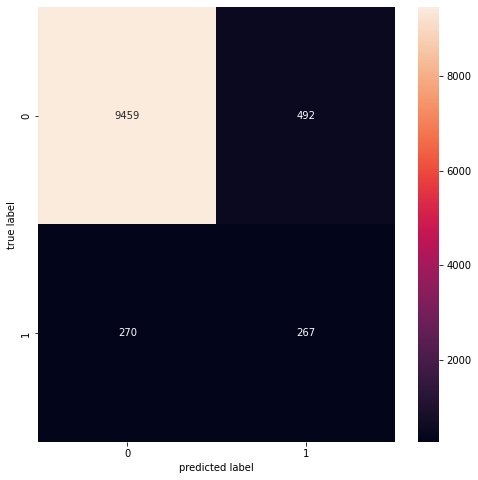

In [18]:
##########################
### Evaluation
##########################
y_pred = model.predict([X_test])
y_pred = y_pred.reshape(-1) // 0.5
y_true = y_test 

bi_f1 =  f1_score(y_true, y_pred) 
bi_recall = recall_score(y_true, y_pred)
bi_precision = precision_score(y_true, y_pred)
bi_acc = accuracy_score(y_true, y_pred)
print("Binary classification: F1-score: {:.3} Recall: {:.3} Precision: {:.3} Accuracy: {:.3}".format(bi_f1, bi_recall, bi_precision, bi_acc))

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
cfm = confusion_matrix(y_true, y_pred) 
ax = sn.heatmap(cfm, annot=True, annot_kws={"size": 10}, fmt='.20g')
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()